In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import random
from PIL import Image
import plotly.express as px

# Lấy dữ liệu

In [3]:
# Tải file từ Google Drive về Colab
# ID file zip được lấy từ link: https://drive.google.com/file/d/1RLcTLP05mAFmXgvf4Ac46HT9uiVvQGAW/view?usp=drive_link
!gdown 1RLcTLP05mAFmXgvf4Ac46HT9uiVvQGAW

# ID lấy từ link: https://drive.google.com/file/d/1McAxDqRWYlbr4E25hes-_VR6z87lGY2Z/view?usp=drive_link
!gdown 1McAxDqRWYlbr4E25hes-_VR6z87lGY2Z -O fishnet_annotations.csv

print("Đã tải xong!")

Downloading...
From (original): https://drive.google.com/uc?id=1RLcTLP05mAFmXgvf4Ac46HT9uiVvQGAW
From (redirected): https://drive.google.com/uc?id=1RLcTLP05mAFmXgvf4Ac46HT9uiVvQGAW&confirm=t&uuid=5c7775d2-65c9-49d8-aef6-91cd4c383827
To: /content/filtered_images.zip
100% 4.66G/4.66G [00:45<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1McAxDqRWYlbr4E25hes-_VR6z87lGY2Z
To: /content/fishnet_annotations.csv
100% 17.1M/17.1M [00:00<00:00, 177MB/s]
Đã tải xong!


In [4]:
# Giải nén file vừa tải
# -o: overwrite
# -q: chế độ im lặng (không hiện danh sách dài file)
# -d: chỉ định thư mục đích để lưu file giải nén (ví dụ: data_folder)
!unzip -o -q *.zip -d /content/data_folder

print("Đã giải nén folder xong")

Đã giải nén folder xong


# Đọc dữ liệu fishnet_annotations.csv

In [5]:
# đọc file fishnet_annotations.csv
df_fishnet = pd.read_csv('/content/fishnet_annotations.csv')

In [6]:
print(df_fishnet.shape)
df_fishnet.head()

(93399, 11)


bbox_id  \
0  00167b08-4a69-44ed-882d-78b6ba31bcd7_0   
1  00167b08-4a69-44ed-882d-78b6ba31bcd7_1   
2  0057ac91-154f-4b38-990e-ee2d20a9d994_0   
3  008a13ed-9cc5-41a9-b420-fa6d84f70ca4_0   
4  008a13ed-9cc5-41a9-b420-fa6d84f70ca4_1   

                                           file_path  \
0  D:\HUS\21. nhap_mon_tri_tue_nhan_tao\FishNet-m...   
1  D:\HUS\21. nhap_mon_tri_tue_nhan_tao\FishNet-m...   
2  D:\HUS\21. nhap_mon_tri_tue_nhan_tao\FishNet-m...   
3  D:\HUS\21. nhap_mon_tri_tue_nhan_tao\FishNet-m...   
4  D:\HUS\21. nhap_mon_tri_tue_nhan_tao\FishNet-m...   

                             image_name   family_name  bbox_index  x_min  \
0  00167b08-4a69-44ed-882d-78b6ba31bcd7  Acanthuridae           0     12   
1  00167b08-4a69-44ed-882d-78b6ba31bcd7  Acanthuridae           1    441   
2  0057ac91-154f-4b38-990e-ee2d20a9d994  Acanthuridae           0      1   
3  008a13ed-9cc5-41a9-b420-fa6d84f70ca4  Acanthuridae           0    200   
4  008a13ed-9cc5-41a9-b420-fa6d84f70ca4  Acanthuridae           1    361   

   y_min  x_max  y_max  bbox_width  bbox_height  
0    113     74    210          62           97  
1    230    489    326          48           96  
2     28    499    252         498          224  
3    133    275    179          75           46  
4    130    417    156          56           26

## Tổng quan bộ dữ liệu fishnet_annotations.csv

In [7]:
df_fishnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93399 entries, 0 to 93398
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   bbox_id      93399 non-null  object
 1   file_path    93399 non-null  object
 2   image_name   93399 non-null  object
 3   family_name  93399 non-null  object
 4   bbox_index   93399 non-null  int64 
 5   x_min        93399 non-null  int64 
 6   y_min        93399 non-null  int64 
 7   x_max        93399 non-null  int64 
 8   y_max        93399 non-null  int64 
 9   bbox_width   93399 non-null  int64 
 10  bbox_height  93399 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 7.8+ MB


In [8]:
# kích thước dataframe
print("Kích thước dataframe:", df_fishnet.shape)

# số lượng image_name duy nhất
print("Số lượng image_name duy nhất:", df_fishnet['image_name'].nunique())

# số lượng family_name duy nhất
print("Số lượng family_name duy nhất:", df_fishnet['family_name'].nunique())

Kích thước dataframe: (93399, 11)
Số lượng image_name duy nhất: 84680
Số lượng family_name duy nhất: 463


In [9]:
# top 5 họ cá xuất hiện nhiều nhất
df_fishnet['family_name'].value_counts().head(5)

family_name
Labridae         5701
Pomacentridae    4518
Cyprinidae       4109
Centrarchidae    3421
Gobiidae         3127
Name: count, dtype: int64

In [10]:
# kiểm tra xem họ cá top cao nhất trên có bao nhiêu image_name khác nhau
print('Labridae:', df_fishnet[df_fishnet['family_name'] == 'Labridae']['image_name'].nunique())
print('Pomacentridae:', df_fishnet[df_fishnet['family_name'] == 'Pomacentridae']['image_name'].nunique())
print('Cyprinidae:', df_fishnet[df_fishnet['family_name'] == 'Cyprinidae']['image_name'].nunique())
print('Centrarchidae:', df_fishnet[df_fishnet['family_name'] == 'Centrarchidae']['image_name'].nunique())
print('Gobiidae:', df_fishnet[df_fishnet['family_name'] == 'Gobiidae']['image_name'].nunique())

Labridae: 5251
Pomacentridae: 3609
Cyprinidae: 3694
Centrarchidae: 3333
Gobiidae: 3027


In [11]:
# top 5 họ cá xuất hiện ít nhất
df_fishnet['family_name'].value_counts().tail(5)

family_name
Derichthyidae     5
Aplodactylidae    5
Diplomystidae     4
Banjosidae        4
Indostomidae      4
Name: count, dtype: int64

In [12]:
# kiểm tra xem họ cá xuất hiện ít nhất có bao nhiêu image_name khác nhau
print('Banjosidae:', df_fishnet[df_fishnet['family_name'] == 'Banjosidae']['image_name'].nunique())
print('Diplomystidae:', df_fishnet[df_fishnet['family_name'] == 'Diplomystidae']['image_name'].nunique())
print('Indostomidae:', df_fishnet[df_fishnet['family_name'] == 'Indostomidae']['image_name'].nunique())
print('Zaniolepididae:', df_fishnet[df_fishnet['family_name'] == 'Zaniolepididae']['image_name'].nunique())
print('Pseudocarchariidae:', df_fishnet[df_fishnet['family_name'] == 'Pseudocarchariidae']['image_name'].nunique())

Banjosidae: 4
Diplomystidae: 4
Indostomidae: 4
Zaniolepididae: 5
Pseudocarchariidae: 5


In [13]:
# kiểm tra xem họ cá nào chỉ có 1 image_name
df_fishnet.groupby('family_name')['image_name'].nunique().loc[lambda x: x == 1]

Series([], Name: image_name, dtype: int64)

In [14]:
# họ cá có số image_name nhiều nhất và ít nhất, với số lượng tương ứng
df_fishnet.groupby('family_name')['image_name'].nunique().agg(['idxmax', 'max', 'idxmin', 'min'])

idxmax      Labridae
max             5251
idxmin    Banjosidae
min                4
Name: image_name, dtype: object

In [15]:
print("Phân bố Class ID:\n")
class_distribution = df_fishnet['family_name'].value_counts().sort_index()
class_distribution_percentage = (class_distribution / class_distribution.sum()) * 100
for class_id, count in class_distribution.items():
    percentage = class_distribution_percentage[class_id]
    print(f"Class ID: {class_id:20} | Số lượng: {count:5} | Tỷ lệ: {percentage:5.2f}%")

Phân bố Class ID:

Class ID: Acanthuridae         | Số lượng:  1885 | Tỷ lệ:  2.02%
Class ID: Acestrorhynchidae    | Số lượng:    26 | Tỷ lệ:  0.03%
Class ID: Acheilognathidae     | Số lượng:    79 | Tỷ lệ:  0.08%
Class ID: Achiridae            | Số lượng:    41 | Tỷ lệ:  0.04%
Class ID: Acipenseridae        | Số lượng:    80 | Tỷ lệ:  0.09%
Class ID: Acropomatidae        | Số lượng:    10 | Tỷ lệ:  0.01%
Class ID: Adrianichthyidae     | Số lượng:    29 | Tỷ lệ:  0.03%
Class ID: Aetobatidae          | Số lượng:   238 | Tỷ lệ:  0.25%
Class ID: Agonidae             | Số lượng:    58 | Tỷ lệ:  0.06%
Class ID: Ailiidae             | Số lượng:    17 | Tỷ lệ:  0.02%
Class ID: Akysidae             | Số lượng:    47 | Tỷ lệ:  0.05%
Class ID: Albulidae            | Số lượng:    25 | Tỷ lệ:  0.03%
Class ID: Alepisauridae        | Số lượng:    12 | Tỷ lệ:  0.01%
Class ID: Alepocephalidae      | Số lượng:    44 | Tỷ lệ:  0.05%
Class ID: Alestidae            | Số lượng:   101 | Tỷ lệ:  0.11%
Class 

In [16]:
df_fishnet.describe()

bbox_index         x_min         y_min         x_max         y_max  \
count  93399.000000  93399.000000  93399.000000  93399.000000  93399.000000   
mean       0.284864     74.541676     76.863360    474.412895    296.255527   
std        1.395998     80.696039     63.637605    136.815642     86.569155   
min        0.000000      0.000000      0.000000      3.000000      9.000000   
25%        0.000000     17.000000     27.000000    374.000000    238.000000   
50%        0.000000     44.000000     61.000000    489.000000    291.000000   
75%        0.000000    107.000000    111.000000    609.000000    352.000000   
max       31.000000    618.000000    515.000000    787.000000    704.000000   

         bbox_width   bbox_height  
count  93399.000000  93399.000000  
mean     399.871219    219.392167  
std      181.047137    104.372967  
min        3.000000      3.000000  
25%      249.000000    142.000000  
50%      430.000000    212.000000  
75%      578.000000    289.000000  
max      771.000000    605.000000

In [17]:
# Thống kê kích thước Bounding Box
print("Kích thước Bounding Box:")

print("\nChiều rộng (bbox_width):")
print(df_fishnet['bbox_width'].describe())

print("\nChiều cao (bbox_height):")
print(df_fishnet['bbox_height'].describe())

Kích thước Bounding Box:

Chiều rộng (bbox_width):
count    93399.000000
mean       399.871219
std        181.047137
min          3.000000
25%        249.000000
50%        430.000000
75%        578.000000
max        771.000000
Name: bbox_width, dtype: float64

Chiều cao (bbox_height):
count    93399.000000
mean       219.392167
std        104.372967
min          3.000000
25%        142.000000
50%        212.000000
75%        289.000000
max        605.000000
Name: bbox_height, dtype: float64


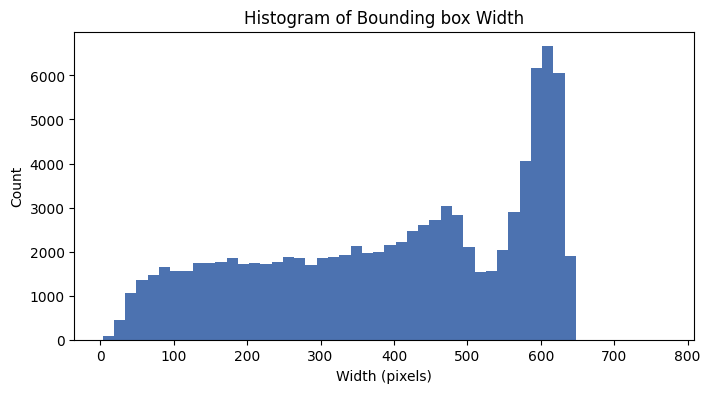

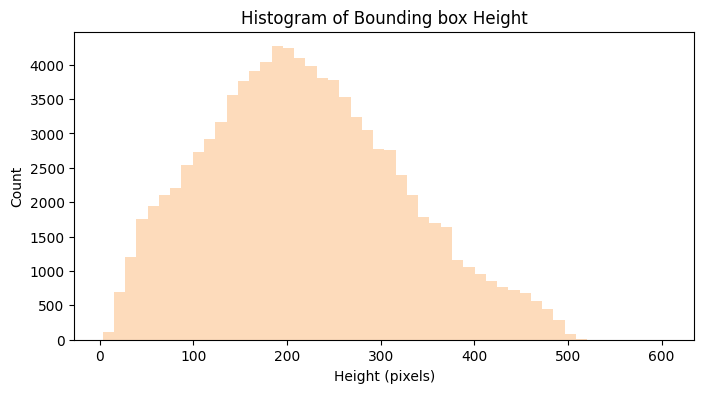

In [18]:
plt.figure(figsize=(8,4))
plt.hist(df_fishnet['bbox_width'], bins=50, color='#4C72B0')
plt.title("Histogram of Bounding box Width")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df_fishnet['bbox_height'], bins=50, color='#FDDBBB')
plt.title("Histogram of Bounding box Height")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")
plt.show()

In [19]:
# kích thước bouding box
df_fishnet['bbox_size'] = df_fishnet['bbox_width'].astype(str) + 'x' + df_fishnet['bbox_height'].astype(str)

In [20]:
# số lượng và tỷ lệ
bbox_size_counts = df_fishnet['bbox_size'].value_counts()
bbox_size_percents = df_fishnet['bbox_size'].value_counts(normalize=True) * 100

# Gộp lại thành một dataframe
bbox_sizes = pd.DataFrame({
    'Số lượng': bbox_size_counts,
    'Tỷ lệ (%)': bbox_size_percents.round(2) # Làm tròn 2 chữ số thập phân
})

bbox_sizes.head(15)

Số lượng  Tỷ lệ (%)
bbox_size                     
612x244           9       0.01
607x224           8       0.01
621x225           8       0.01
60x41             7       0.01
593x178           7       0.01
609x308           7       0.01
610x242           7       0.01
624x207           7       0.01
608x206           7       0.01
623x226           7       0.01
609x191           7       0.01
500x330           7       0.01
606x196           7       0.01
630x245           7       0.01
618x221           7       0.01

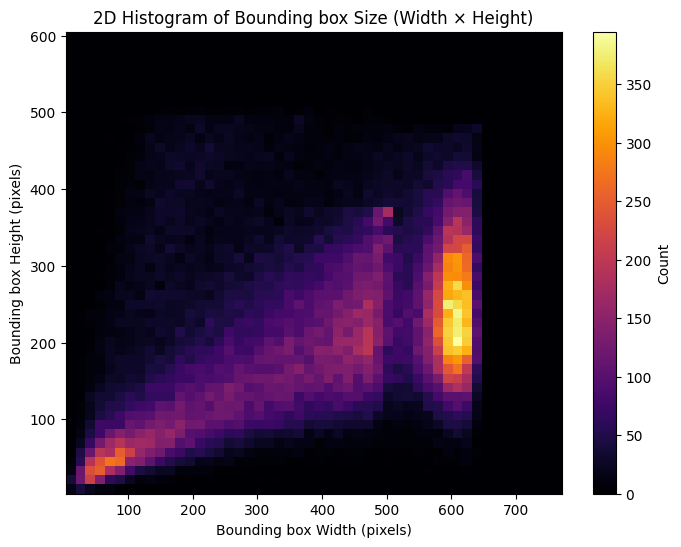

In [21]:
plt.figure(figsize=(8, 6))
plt.hist2d(df_fishnet['bbox_width'], df_fishnet['bbox_height'], bins=50, cmap='inferno')
plt.colorbar(label="Count")
plt.xlabel("Bounding box Width (pixels)")
plt.ylabel("Bounding box Height (pixels)")
plt.title("2D Histogram of Bounding box Size (Width × Height)")
plt.show()

# Kiểm tra ảnh trong folder content/data_folder/filtered_images

## kích thước ảnh

In [22]:
def get_image_info(folder_path):
    data = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Chỉ nhận file ảnh
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):

                img_path = os.path.join(root, file)

                # Lấy tên lớp (folder nhỏ (đại diện cho họ cá) bên trong filtered_images)
                family_name = os.path.basename(os.path.dirname(img_path))

                # Đọc ảnh bằng OpenCV
                img = cv2.imread(img_path)

                if img is not None:
                    h, w = img.shape[:2]
                    data.append([img_path, family_name, w, h])

    # Tạo DataFrame
    df = pd.DataFrame(data, columns=["path", "family_name", "width", "height"])
    return df


In [23]:
folder = "/content/data_folder/filtered_images"
df_images = get_image_info(folder)

In [24]:
print(df_images.shape)
df_images.head()

(84680, 4)


path family_name  width  \
0  /content/data_folder/filtered_images/Rhinidae/...    Rhinidae    600   
1  /content/data_folder/filtered_images/Rhinidae/...    Rhinidae    600   
2  /content/data_folder/filtered_images/Rhinidae/...    Rhinidae    640   
3  /content/data_folder/filtered_images/Rhinidae/...    Rhinidae    640   
4  /content/data_folder/filtered_images/Rhinidae/...    Rhinidae    640   

   height  
0     399  
1     399  
2     254  
3     377  
4     332

In [25]:
df_images.describe()

width        height
count  84680.000000  84680.000000
mean     547.481483    371.425827
std       95.007813     78.710661
min       75.000000     53.000000
25%      500.000000    326.000000
50%      500.000000    375.000000
75%      640.000000    427.000000
max      800.000000    922.000000

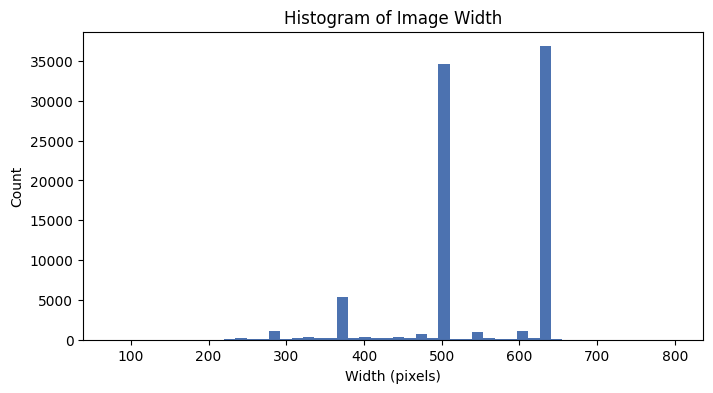

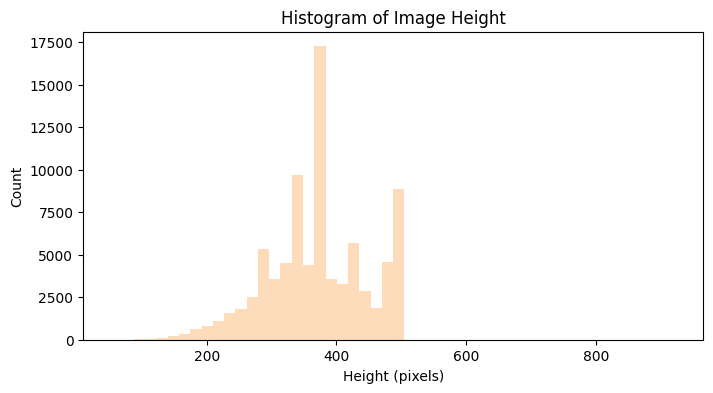

In [26]:
plt.figure(figsize=(8,4))
plt.hist(df_images['width'], bins=50, color='#4C72B0')
plt.title("Histogram of Image Width")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df_images['height'], bins=50, color='#FDDBBB')
plt.title("Histogram of Image Height")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")
plt.show()

In [27]:
# kích thước ảnh
df_images['size'] = df_images['width'].astype(str) + 'x' + df_images['height'].astype(str)

In [28]:
# số lượng và tỷ lệ
size_counts = df_images['size'].value_counts()
size_percents = df_images['size'].value_counts(normalize=True) * 100

# Gộp lại thành một dataframe
sizes = pd.DataFrame({
    'Số lượng': size_counts,
    'Tỷ lệ (%)': size_percents.round(2) # Làm tròn 2 chữ số thập phân
})

sizes.head(15)

Số lượng  Tỷ lệ (%)
size                        
500x375     12973      15.32
375x500      5045       5.96
500x333      4371       5.16
500x281      2004       2.37
640x480      1773       2.09
281x500       910       1.07
640x427       881       1.04
500x334       820       0.97
640x435       756       0.89
640x426       631       0.75
500x332       519       0.61
500x500       515       0.61
640x434       363       0.43
640x425       327       0.39
500x335       303       0.36

Biểu đồ 2D Histogram cho thấy kích thước ảnh (*width x height*) không phân bố ngẫu nhiên, mà chủ yếu tập trung vào 1 số kích thước chính

- Theo thống kê ở trên: **500x375: 12973 ảnh (điểm màu vàng sáng trong biểu đồ)**: Tập trung khoảng 15.32% tổng số ảnh vào kích thước này.

- Các vệt dọc:
  - Có 1 vệt dọc ở **width = 500px**, height dao động từ khoảng **280px đến 380px**
  - Có 1 vệt khác ở **width = 640px**, height dao động nhiều hơn, từ **200px đến 500px**

  => Rất nhiều ảnh có chiều rộng cố định nhưng chiều cao lại thay đổi tùy ý.

- Khoảng màu đen chiếm phần lớn.

=> Vì đa số ảnh gốc có width chỉ khoảng 500px hoặc 640px, nên khi chọn kích thước input model, có thể chọn kích thước 416x416, hoặc 512x512 hoặc 640x640 (bội số của 32)

Nhưng nếu resize về hình vuông, ảnh có thể bị méo

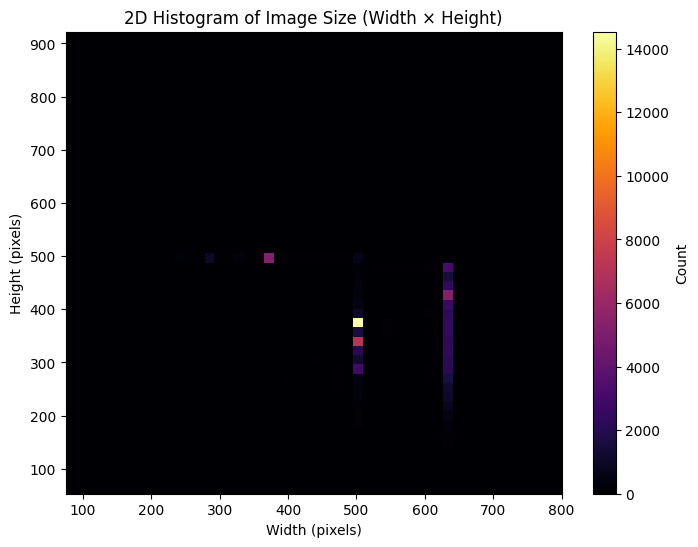

In [29]:
# Do dữ liệu chỉ có 2 trường số width x height, nên 2D Histogram cũng là heatmap cho dữ liệu
plt.figure(figsize=(8, 6))
plt.hist2d(df_images['width'], df_images['height'], bins=50, cmap='inferno')
plt.colorbar(label="Count")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.title("2D Histogram of Image Size (Width × Height)")
plt.show()

In [30]:
# xem tỉ lệ width / height của các ảnh
df_images['ratio'] = df_images['width'] / df_images['height']

In [31]:
from fractions import Fraction

def to_fraction(w, h):
    return f"{Fraction(w, h).limit_denominator()}"

df_images['ratio_fraction'] = df_images.apply(lambda row: to_fraction(row['width'], row['height']), axis=1)

In [32]:
df_images['ratio'].describe()

count    84680.000000
mean         1.569039
std          0.533121
min          0.180000
25%          1.333333
50%          1.498829
75%          1.779359
max         12.075472
Name: ratio, dtype: float64

In [33]:
df_images[['ratio', 'ratio_fraction']].value_counts().head(15)

ratio     ratio_fraction
1.333333  4/3               14804
0.750000  3/4                5084
1.501502  500/333            4371
1.779359  500/281            2004
0.562000  281/500             910
1.498829  640/427             881
1.497006  250/167             822
1.471264  128/87              756
1.502347  320/213             631
1.000000  1                   558
1.506024  125/83              520
1.666667  5/3                 402
1.474654  320/217             363
1.505882  128/85              327
1.492537  100/67              309
Name: count, dtype: int64

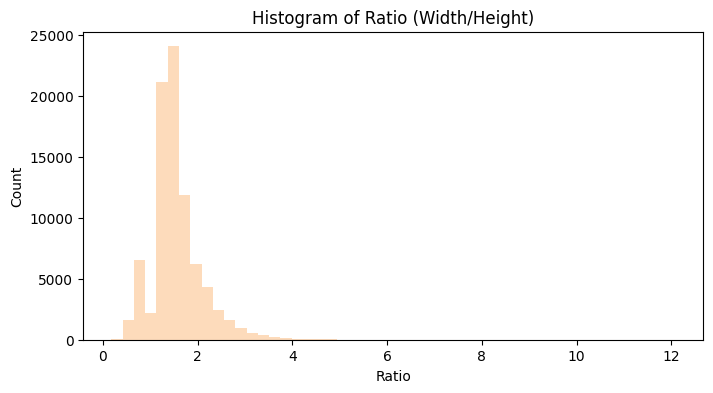

In [34]:
# vẽ phân phối tỉ lệ khung hình
plt.figure(figsize=(8,4))
plt.hist(df_images['ratio'], bins=50, color='#FDDBBB')
plt.title("Histogram of Ratio (Width/Height)")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.show()

In [35]:
df_images['megapixels'] = df_images['width'] * df_images['height'] / 1_000_000
df_images['megapixels'].describe()

count    84680.000000
mean         0.201325
std          0.049869
min          0.006325
25%          0.166500
50%          0.187500
75%          0.236800
max          0.529228
Name: megapixels, dtype: float64

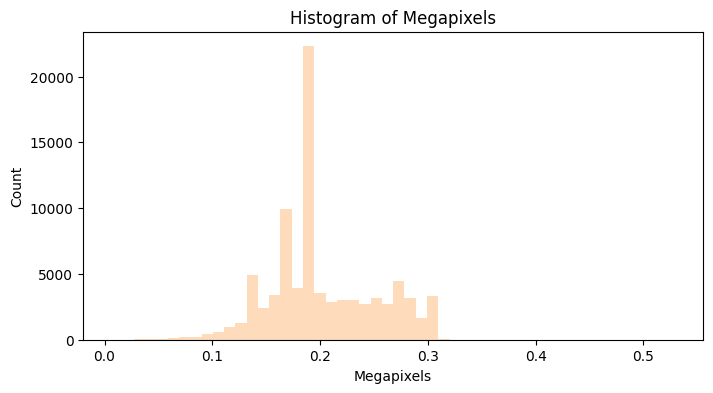

In [36]:
plt.figure(figsize=(8,4))
plt.hist(df_images['megapixels'], bins=50, color='#FDDBBB')
plt.title("Histogram of Megapixels")
plt.xlabel("Megapixels")
plt.ylabel("Count")
plt.show()

Megapixels là một cột được tính toán bằng cách nhân chiều rộng (width) và chiều cao (height) của ảnh, sau đó chia cho 1_000_000.

Dựa trên dữ liệu thống kê, có thể thấy độ phân giải của các ảnh trên toàn bộ dữ liệu thấp
- Giá trị Megapixels trung bình của các ảnh là rất thấp, chỉ khoảng 0.20 MP.
- Ảnh có độ phân giải cao nhất trong bộ dữ liệu cũng chỉ đạt tối đa 0.529228 MP.

Tuy vậy, độ lệch chuẩn lại chỉ khoảng 0.05 và khoảng IQR hẹp (0.17 - 0.24), cho thấy hầu hết các ảnh có độ phân giải tập trung dày đặc xung quanh mức trung bình 0.20 MP. Từ đó, nhận thấy rằng toàn bộ dữ liệu đang được xử lý ở quy mô độ phân giải rất nhỏ nhưng có tính đồng nhất cao.

**=> Với độ phân giải thấp, khối lượng tính toán mô hình sẽ giảm đáng kể. Tuy nhiên, độ phân giải thấp là một rào cản lớn cho bài toán Fine-grained Classification (Phân loại chi tiết). Các đặc trưng quan trọng để phân biệt các loài cá có ngoại hình giống nhau (như vân vảy, gai vây, màu mắt) có thể bị mờ hoặc mất đi, làm giảm độ chính xác của mô hình.**

## thống kê số lượng ảnh mỗi họ cá

In [37]:
# phân bố số lượng ảnh từng lớp
family_counts = df_images['family_name'].value_counts()

In [38]:
family_counts.describe()

count     463.000000
mean      182.894168
std       493.803867
min         4.000000
25%        11.000000
50%        30.000000
75%       124.000000
max      5251.000000
Name: count, dtype: float64

In [39]:
total_families = len(family_counts)
total_images = df_images.shape[0]
average_images_per_category = family_counts.mean()
mode_images = family_counts.mode()[0]
median_images = family_counts.median()
skewness_images = family_counts.skew()
kurtosis_images = family_counts.kurtosis()

print("Tổng số loại cá:", total_families)
print("Tổng số ảnh:", total_images)
print(f"Số ảnh trung bình mỗi loại: {average_images_per_category:.2f}")
print(f"Mode: {mode_images:.2f}")
print(f"Số ảnh trung vị mỗi loại: {median_images:.2f}")
print(f"Skewness (Độ lệch): {skewness_images:.2f}")
print(f"Kurtosis (Độ nhọn): {kurtosis_images:.2f}")

Tổng số loại cá: 463
Tổng số ảnh: 84680
Số ảnh trung bình mỗi loại: 182.89
Mode: 5.00
Số ảnh trung vị mỗi loại: 30.00
Skewness (Độ lệch): 5.76
Kurtosis (Độ nhọn): 41.45


- 50% số họ cá có số lượng ảnh thấp hơn 30 ảnh, trong khi đó, trung bình số ảnh là 182, có thể suy ra rằng có vài loài cá có số lượng ảnh cực lớn đang kéo mức trung bình lên, trong khi đa số các loài khác đều có dữ liệu không nhiều.

- Phần lớn các loài có dúng 5 ảnh

- Độ lệch =  5.76 > 0 => phân phối dữ liệu bị lệch phải rất nhiều.
Đa số các loài cá có rất ít ảnh, nhưng lại có một vài loài "thiểu số" có số lượng ảnh khổng lồ kéo đuôi đồ thị dài ngoằng về phía bên phải.

- Độ nhọn = 41.45 => Đỉnh rất nhọn, tập trung hầu hết các loài cá ít ảnh, trong khi giá trị ngoại lai lại cực kỳ xa so với trung bình.

**=> Khi train model, sử dụng xoay, lật ảnh để tăng ảnh của các lớp ít**

In [40]:
# số lượng loài cá có 5 ảnh
len(family_counts[family_counts == 5])

25

In [41]:
min_images = family_counts.min()
max_images = family_counts.max()

print("Số ảnh ít nhất trong một loại:", min_images)
print("Số ảnh nhiều nhất trong một loại:", max_images)

Số ảnh ít nhất trong một loại: 4
Số ảnh nhiều nhất trong một loại: 5251


In [42]:
# các loài cá có số ảnh dưới 10
under_10_families = family_counts[family_counts <= 10]
print("Tổng số loài có ít hơn 10 ảnh:", len(under_10_families))
under_10_families

Tổng số loài có ít hơn 10 ảnh: 106


family_name
Malakichthyidae     10
Setarchidae         10
Rhinochimaeridae    10
Scorpididae         10
Polyodontidae       10
                    ..
Diplomystidae        4
Gonorynchidae        4
Banjosidae           4
Spratelloididae      4
Indostomidae         4
Name: count, Length: 106, dtype: int64

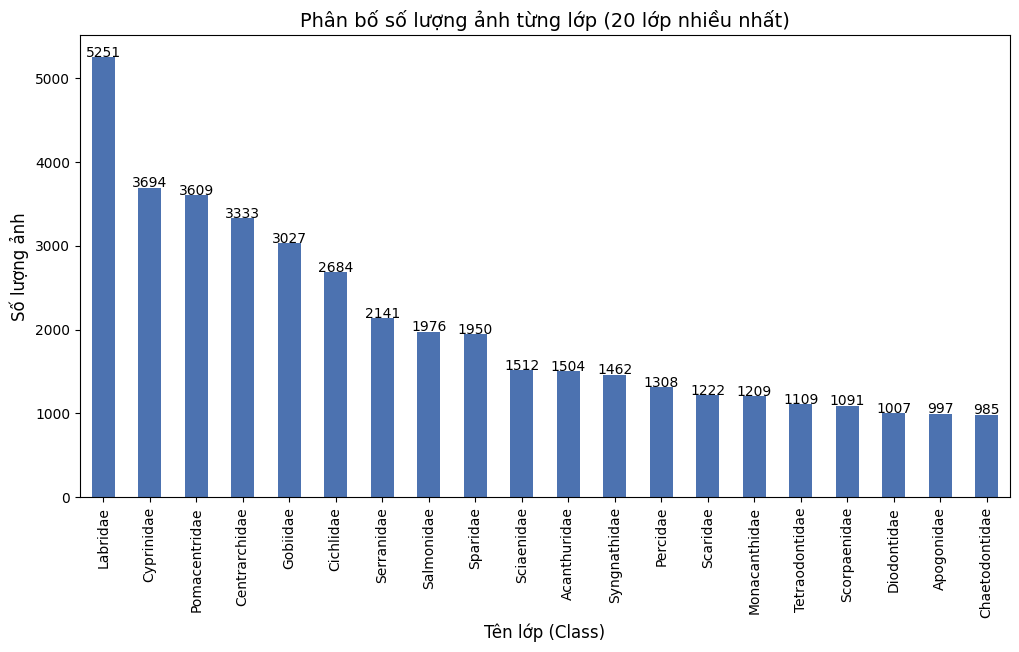

In [43]:
family_counts_top_20 = family_counts[:20]

# Vẽ biểu đồ cột (Bar chart)
plt.figure(figsize=(12, 6))
family_counts_top_20.plot(kind='bar', color='#4C72B0')

# Thêm nhãn cho rõ ràng
plt.title('Phân bố số lượng ảnh từng lớp (20 lớp nhiều nhất)', fontsize=14)
plt.xlabel('Tên lớp (Class)', fontsize=12)
plt.ylabel('Số lượng ảnh', fontsize=12)

# Hiển thị số lượng cụ thể trên đầu mỗi cột
for i, v in enumerate(family_counts_top_20):
    plt.text(i, v + 5, str(v), ha='center', fontsize=10)

plt.show()

In [44]:
# Đếm số lượng và reset_index để thành dataframe
data_family_counts = family_counts.reset_index()
data_family_counts.columns = ['Family', 'Quantity'] # Đặt lại tên cột cho đẹp

# Vẽ biểu đồ tương tác bằng Plotly
fig = px.bar(data_family_counts,
             x='Family',
             y='Quantity',
             title='Class Distribution - 463 families',
             height=600)

# Thêm thanh trượt (Range Slider)
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="category"))

fig.show()

In [45]:
# chuyển family_counts thành dataframe
df_family_counts = pd.DataFrame({'family': family_counts.index, 'count': family_counts.values})

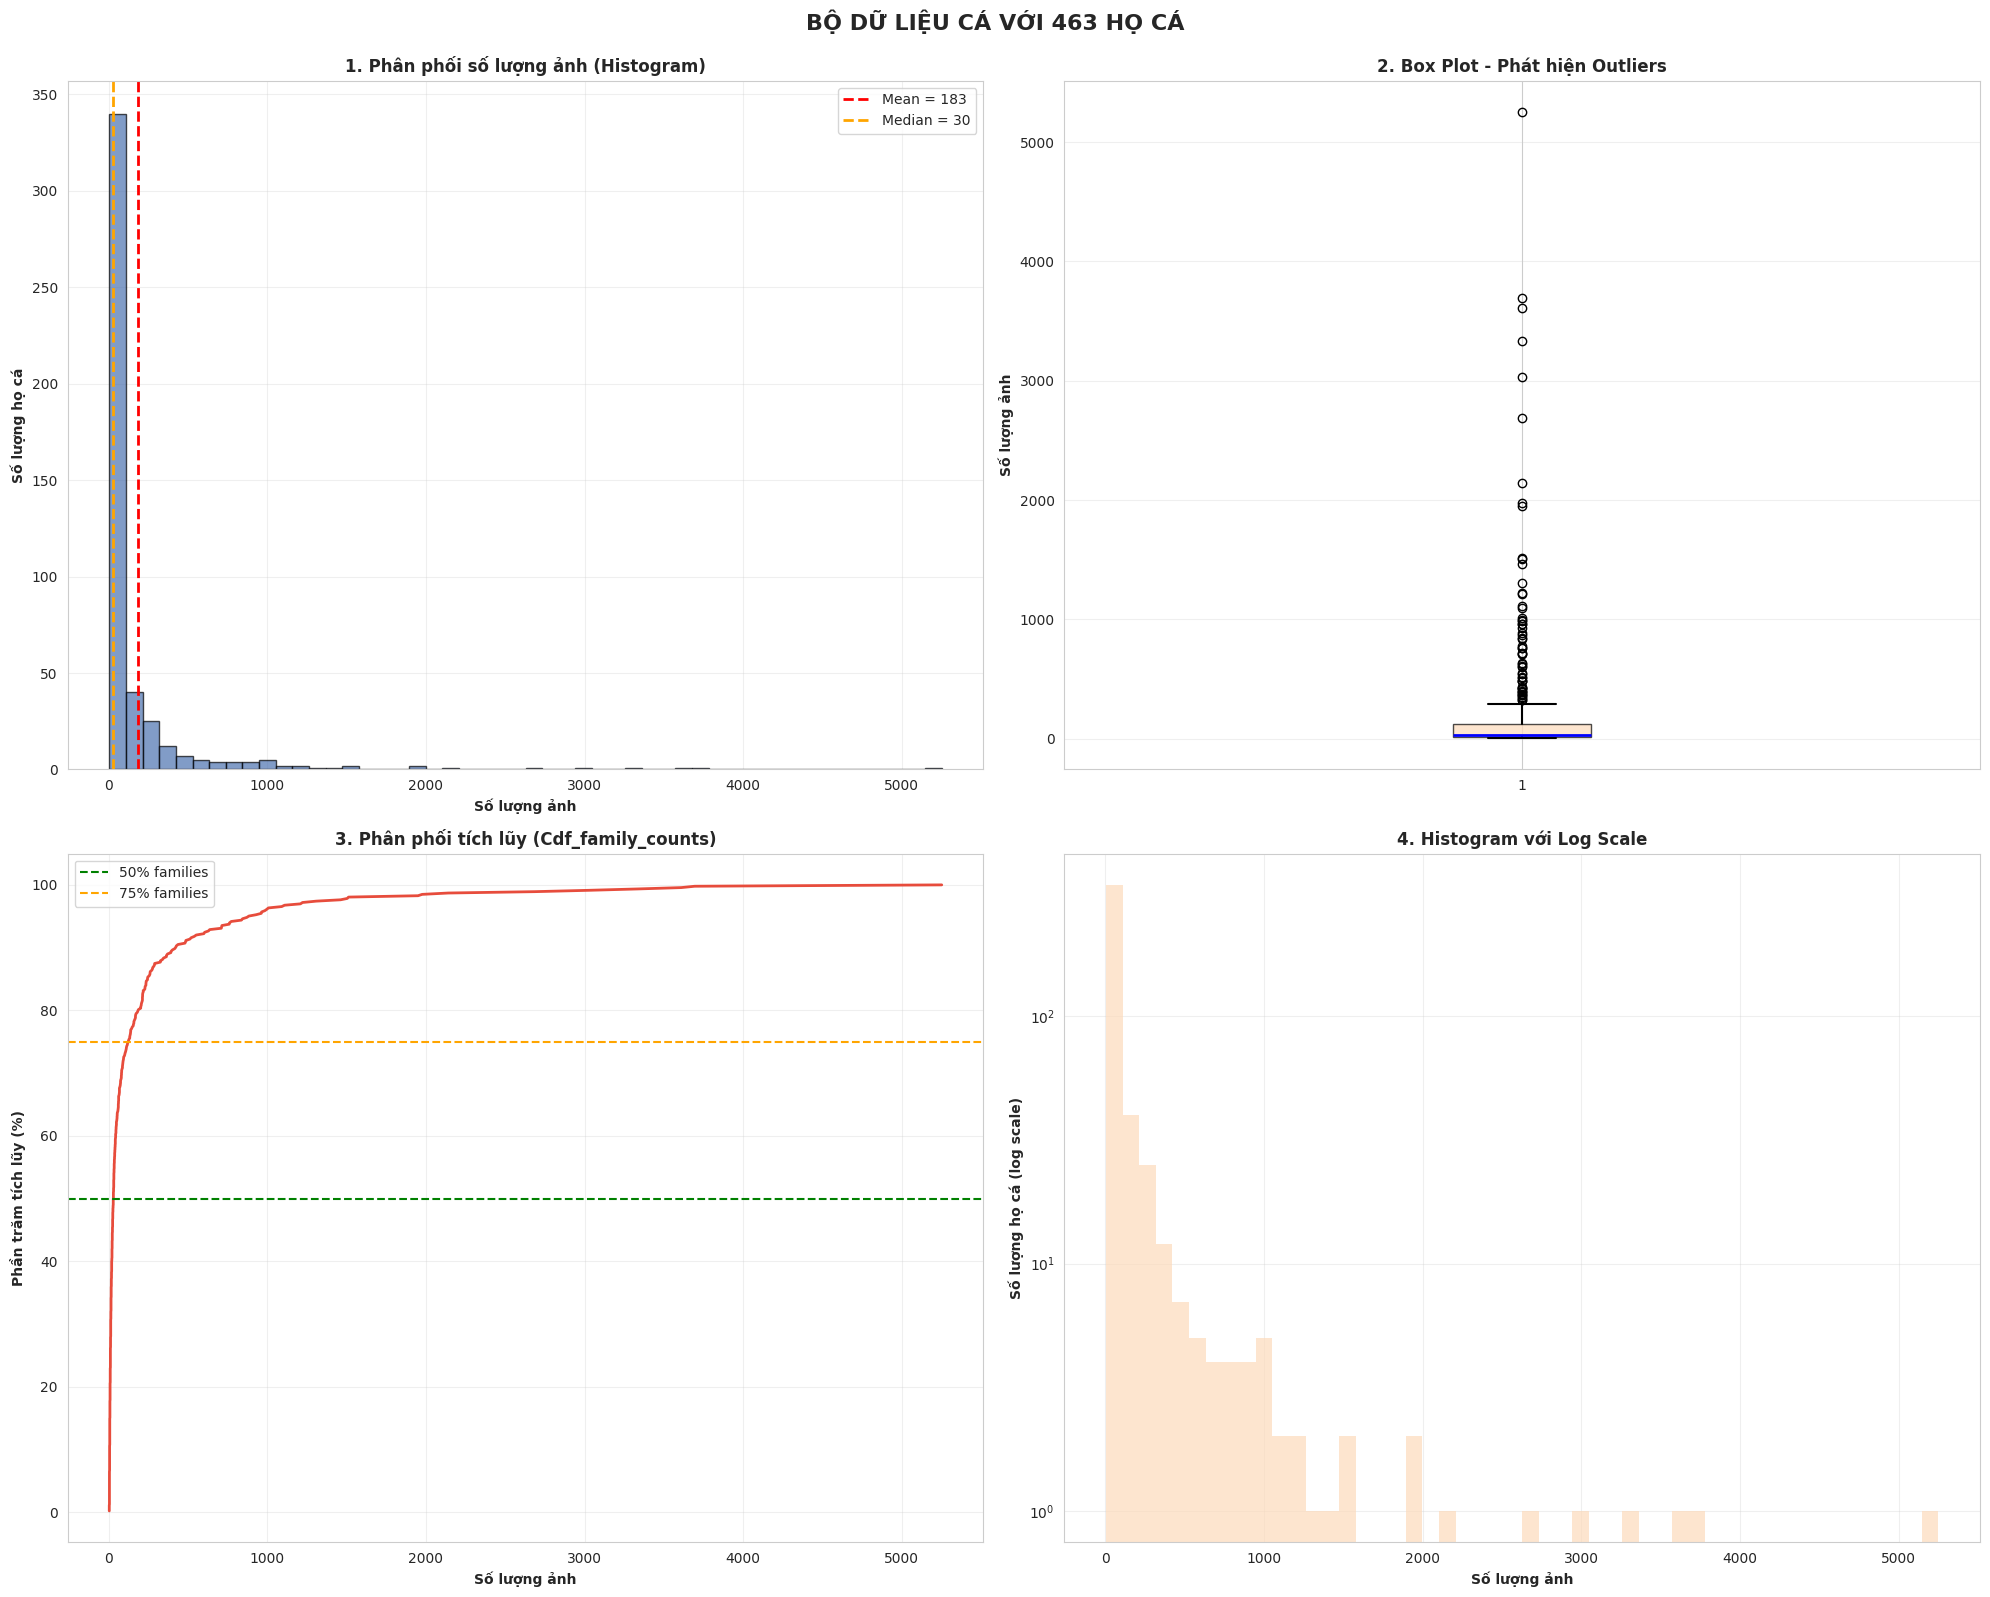

In [46]:
# Thiết lập style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

# Tạo subplot với 4 biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('BỘ DỮ LIỆU CÁ VỚI 463 HỌ CÁ', fontsize=16, fontweight='bold', y=0.995)

# 1. Histogram với
axes[0, 0].hist(df_family_counts['count'], bins=50, color='#4C72B0', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Số lượng ảnh', fontweight='bold')
axes[0, 0].set_ylabel('Số lượng họ cá', fontweight='bold')
axes[0, 0].set_title('1. Phân phối số lượng ảnh (Histogram)', fontweight='bold')
axes[0, 0].axvline(df_family_counts['count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {df_family_counts["count"].mean():.0f}')
axes[0, 0].axvline(df_family_counts['count'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median = {df_family_counts["count"].median():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box Plot
axes[0, 1].boxplot(df_family_counts['count'], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='#FDDBBB', alpha=0.7),
                    medianprops=dict(color='blue', linewidth=2),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5))
axes[0, 1].set_ylabel('Số lượng ảnh', fontweight='bold')
axes[0, 1].set_title('2. Box Plot - Phát hiện Outliers', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Cumulative Distribution
sorted_counts = np.sort(df_family_counts['count'].values)
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
axes[1, 0].plot(sorted_counts, cumulative, color='#e74c3c', linewidth=2)
axes[1, 0].set_xlabel('Số lượng ảnh', fontweight='bold')
axes[1, 0].set_ylabel('Phần trăm tích lũy (%)', fontweight='bold')
axes[1, 0].set_title('3. Phân phối tích lũy (Cdf_family_counts)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(50, color='green', linestyle='--', linewidth=1.5, label='50% families')
axes[1, 0].axhline(75, color='orange', linestyle='--', linewidth=1.5, label='75% families')
axes[1, 0].legend()

# 4. Log Scale Histogram
axes[1, 1].hist(df_family_counts['count'], bins=50, color='#FDDBBB', alpha=0.7, edgecolor='none')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel('Số lượng ảnh', fontweight='bold')
axes[1, 1].set_ylabel('Số lượng họ cá (log scale)', fontweight='bold')
axes[1, 1].set_title('4. Histogram với Log Scale', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
# Kiểm tra số lượng outliers bằng IQR method
Q1 = df_family_counts['count'].quantile(0.25)
Q3 = df_family_counts['count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_family_counts[(df_family_counts['count'] < lower_bound) | (df_family_counts['count'] > upper_bound)]

print(f"Số lượng outliers phát hiện được: {len(outliers)}")
print("lower_bound:", lower_bound)
print("upper_bound:", upper_bound)
outliers

Số lượng outliers phát hiện được: 58
lower_bound: -158.5
upper_bound: 293.5


family  count
0           Labridae   5251
1         Cyprinidae   3694
2      Pomacentridae   3609
3      Centrarchidae   3333
4           Gobiidae   3027
5          Cichlidae   2684
6         Serranidae   2141
7         Salmonidae   1976
8           Sparidae   1950
9         Sciaenidae   1512
10      Acanthuridae   1504
11      Syngnathidae   1462
12          Percidae   1308
13          Scaridae   1222
14     Monacanthidae   1209
15    Tetraodontidae   1109
16      Scorpaenidae   1091
17       Diodontidae   1007
18        Apogonidae    997
19    Chaetodontidae    985
20        Carangidae    964
21       Ictaluridae    962
22          Mullidae    930
23        Blenniidae    884
24       Ostraciidae    871
25        Kyphosidae    844
26        Haemulidae    837
27        Dasyatidae    773
28     Lepisosteidae    762
29       Poeciliidae    760
30     Pomacanthidae    714
31        Muraenidae    712
32        Lutjanidae    710
33        Characidae    637
34       Leuciscidae    629
35        Fundulidae    605
36  Cheilodactylidae    600
37    Tripterygiidae    552
38      Aulostomidae    540
39      Loricariidae    520
40        Girellidae    512
41         Moronidae    487
42          Esocidae    485
43    Gasterosteidae    481
44         Rivulidae    437
45      Myliobatidae    427
46    Carcharhinidae    423
47     Orectolobidae    417
48         Clupeidae    402
49         Mugilidae    394
50      Catostomidae    392
51   Platycephalidae    371
52  Nothobranchiidae    365
53           Ariidae    364
54          Cottidae    346
55      Sphyraenidae    340
56      Gobiesocidae    327
57        Danionidae    326

Tổng số ảnh: 84,680
Tổng số họ cá: 463

80% số lượng ảnh đến từ 76 họ cá (16.4% tổng số họ)
20% họ cá đầu chiếm 84.1% tổng số ảnh


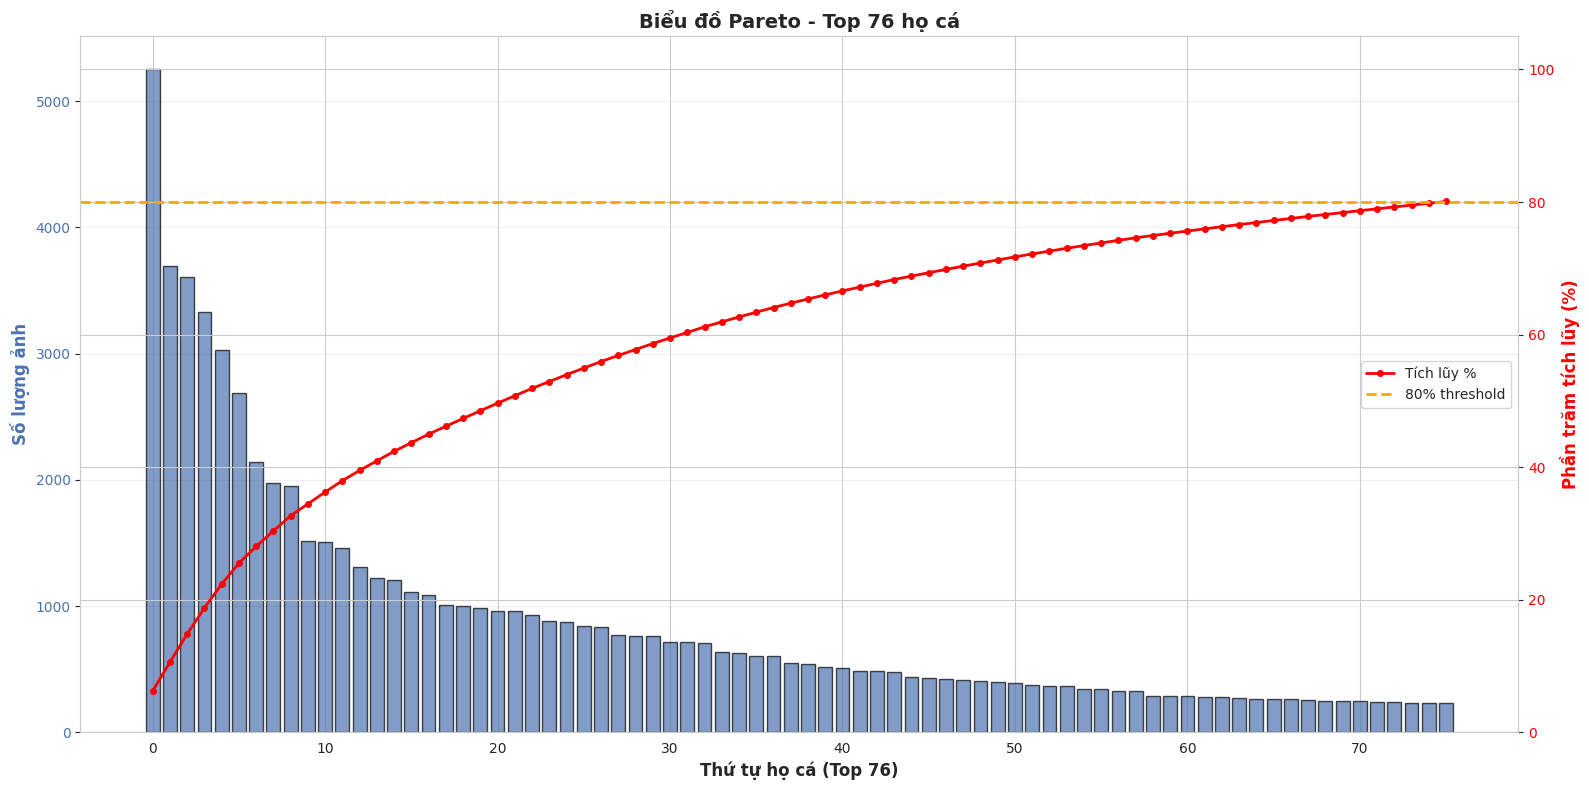


TOP 76 HỌ CÁ (CHIẾM 80% DỮ LIỆU)
          family  count  Cumulative_Percentage
        Labridae   5251               6.200992
      Cyprinidae   3694              10.563297
   Pomacentridae   3609              14.825224
   Centrarchidae   3333              18.761219
        Gobiidae   3027              22.335853
       Cichlidae   2684              25.505432
      Serranidae   2141              28.033774
      Salmonidae   1976              30.367265
        Sparidae   1950              32.670052
      Sciaenidae   1512              34.455598
    Acanthuridae   1504              36.231696
    Syngnathidae   1462              37.958196
        Percidae   1308              39.502834
        Scaridae   1222              40.945914
   Monacanthidae   1209              42.373642
  Tetraodontidae   1109              43.683278
    Scorpaenidae   1091              44.971658
     Diodontidae   1007              46.160841
      Apogonidae    997              47.338214
  Chaetodontidae    985   

In [48]:
# Tính phần trăm tích lũy
df_sorted =df_family_counts.sort_values('count', ascending=False).reset_index(drop=True)
df_sorted['Cumulative_Images'] =df_sorted['count'].cumsum()
df_sorted['Cumulative_Percentage'] = (df_sorted['Cumulative_Images'] /df_sorted['count'].sum()) * 100
df_sorted['family_Percentage'] = ((df_sorted.index + 1) / len(df_sorted)) * 100

# Tìm điểm 80%
pareto_80_idx =df_sorted[df_sorted['Cumulative_Percentage'] >= 80].index[0]
pareto_80_families = pareto_80_idx + 1
pareto_80_pct = (pareto_80_families / len(df_sorted)) * 100

print(f"Tổng số ảnh: {df_sorted['count'].sum():,}")
print(f"Tổng số họ cá: {len(df_sorted)}")
print(f"\n80% số lượng ảnh đến từ {pareto_80_families} họ cá ({pareto_80_pct:.1f}% tổng số họ)")
print(f"20% họ cá đầu chiếm {df_sorted.head(int(len(df_sorted)*0.2))['count'].sum() /df_sorted['count'].sum() * 100:.1f}% tổng số ảnh")

# Vẽ Pareto Chart
fig, ax1 = plt.subplots(figsize=(16, 8))

# Bar chart
x_pos = np.arange(min(76, len(df_sorted)))
bars = ax1.bar(x_pos,df_sorted['count'].head(76), color='#4C72B0', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Thứ tự họ cá (Top 76)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Số lượng ảnh', fontweight='bold', fontsize=12, color='#4C72B0')
ax1.tick_params(axis='y', labelcolor='#4C72B0')

# Line chart
ax2 = ax1.twinx()
ax2.plot(x_pos,df_sorted['Cumulative_Percentage'].head(76), color='red', marker='o',
         linewidth=2, markersize=4, label='Tích lũy %')
ax2.set_ylabel('Phần trăm tích lũy (%)', fontweight='bold', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(80, color='orange', linestyle='--', linewidth=2, label='80% threshold')
ax2.set_ylim([0, 105])

# Title and grid
plt.title('Biểu đồ Pareto - Top 76 họ cá', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')
ax2.legend(loc='center right')

plt.tight_layout()
plt.show()

print(f"\nTOP {pareto_80_families} HỌ CÁ (CHIẾM 80% DỮ LIỆU)")
print(df_sorted.head(pareto_80_families)[['family', 'count', 'Cumulative_Percentage']].to_string(index=False))

## Chia ra thành 3 nhóm: Common, Medium, Rare

- 75% loài cá có số lượng ảnh ít hơn 124 ảnh

Thêm 1 cột phân loại cho bộ dữ liệu dựa trên tần suất lớp tương ứng: common, medium, rare.
- Theo các tiêu chí:
  - Common - Lớp phổ biến: Các lớp đại diện cho 25% tổng số hình ảnh
  - Medium - Lớp trung bình: Các lớp tiếp theo đại diện cho 50% tổng số hình ảnh
  - Rare - Lớp hiếm: Các lớp còn lại, đại diện cho 25% tổng số hình ảnh

In [49]:
# Tính tỷ lệ tích lũy (Cumulative Percentage) cho từng loài
# Sắp xếp từ nhiều nhất -> ít nhất trước khi tính
# family_counts
cum_perc = family_counts.cumsum() / family_counts.sum()

# Hàm phân loại
def classify(p):
    if p <= 0.25: return 'Common'    # Top 25% đầu
    if p <= 0.75: return 'Medium'    # 25% tiếp theo + 50% = 75%
    return 'Rare'                    # 25% còn lại

# 3. Áp dụng vào DataFrame gốc (Map từ tên loài sang nhóm)
df_images['group'] = df_images['family_name'].map(cum_perc.apply(classify))

# Xem kết quả kiểm tra
print(df_images['group'].value_counts())
df_images[['family_name', 'group']].head()

group
Medium    44549
Rare      21217
Common    18914
Name: count, dtype: int64


family_name group
0    Rhinidae  Rare
1    Rhinidae  Rare
2    Rhinidae  Rare
3    Rhinidae  Rare
4    Rhinidae  Rare

In [50]:
# Kiểm tra xem bao nhiêu họ cá ở mỗi nhóm
unique_classes = df_images[['family_name', 'group']].drop_duplicates()

# Đếm số lượng họ cá trong từng nhóm
class_counts_by_group = unique_classes['group'].value_counts()

print("Số lượng họ cá trong mỗi nhóm:")
print(class_counts_by_group)

# 3. (Tùy chọn) Xem tỷ lệ phần trăm số họ cá
print("\nTỷ lệ % số họ cá:")
print((class_counts_by_group / class_counts_by_group.sum() * 100).round(2))

Số lượng họ cá trong mỗi nhóm:
group
Rare      404
Medium     54
Common      5
Name: count, dtype: int64

Tỷ lệ % số họ cá:
group
Rare      87.26
Medium    11.66
Common     1.08
Name: count, dtype: float64


87.26% họ cá, chỉ đóng góp được 25% số ảnh cho toàn bộ dữ liệu

In [51]:
common_fish_name = unique_classes[unique_classes['group'] == 'Common']['family_name'].tolist()
medium_fish_name = unique_classes[unique_classes['group'] == 'Medium']['family_name'].tolist()
rare_fish_name = unique_classes[unique_classes['group'] == 'Rare']['family_name'].tolist()

print("Common:", common_fish_name)
print("Medium:", medium_fish_name)
print("Rare:", rare_fish_name)

Common: ['Labridae', 'Centrarchidae', 'Cyprinidae', 'Pomacentridae', 'Gobiidae']
Medium: ['Ostraciidae', 'Catostomidae', 'Tripterygiidae', 'Cichlidae', 'Carangidae', 'Poeciliidae', 'Apogonidae', 'Monacanthidae', 'Serranidae', 'Ariidae', 'Lutjanidae', 'Haemulidae', 'Diodontidae', 'Syngnathidae', 'Cottidae', 'Orectolobidae', 'Sphyraenidae', 'Acanthuridae', 'Ictaluridae', 'Loricariidae', 'Pomacanthidae', 'Mugilidae', 'Girellidae', 'Lepisosteidae', 'Sciaenidae', 'Rivulidae', 'Gobiesocidae', 'Percidae', 'Nothobranchiidae', 'Blenniidae', 'Cheilodactylidae', 'Chaetodontidae', 'Cirrhitidae', 'Scorpaenidae', 'Leuciscidae', 'Sparidae', 'Danionidae', 'Esocidae', 'Salmonidae', 'Fundulidae', 'Characidae', 'Carcharhinidae', 'Muraenidae', 'Mullidae', 'Moronidae', 'Dasyatidae', 'Scaridae', 'Clupeidae', 'Platycephalidae', 'Gasterosteidae', 'Tetraodontidae', 'Kyphosidae', 'Aulostomidae', 'Myliobatidae']
Rare: ['Rhinidae', 'Ailiidae', 'Gigantactinidae', 'Anablepidae', 'Osteoglossidae', 'Albulidae', 'Nemi

In [52]:
# Đếm số lượng ảnh của từng loài kèm theo nhóm của nó
# Kết quả là một Series có index kép (group, family_name)
group_counts = df_images.groupby(['group', 'family_name']).size()

# Tính describe cho từng nhóm
# Level 0 chính là cột 'group'
group_stats = group_counts.groupby(level=0).describe()

# In kết quả
group_stats

count         mean         std     min     25%     50%      75%  \
group                                                                     
Common    5.0  3782.800000  861.286364  3027.0  3333.0  3609.0  3694.00   
Medium   54.0   824.981481  512.752229   290.0   429.5   711.0   994.00   
Rare    404.0    52.517327   67.324238     4.0    10.0    23.0    62.25   

           max  
group           
Common  5251.0  
Medium  2684.0  
Rare     289.0

# Hiển thị 1 vài ảnh cho 1 vài họ cá

In [53]:
def show_samples_per_class(df, class_name, num=3):
    samples = df[df['family_name'] == class_name]['path'].sample(num)
    img_count = int(df_family_counts[df_family_counts['family'] == class_name]['count'])
    plt.figure(figsize=(12,4))
    for i, img_path in enumerate(samples):
        plt.subplot(1, num, i+1)
        plt.imshow(plt.imread(img_path))
        plt.axis("off")
    plt.suptitle(f'{class_name}\n({img_count} ảnh)')
    plt.show()

In [54]:
class_names = df_fishnet['family_name'].unique()
len(class_names), class_names[:10]

(463,
 array(['Acanthuridae', 'Acestrorhynchidae', 'Acheilognathidae',
        'Achiridae', 'Acipenseridae', 'Acropomatidae', 'Adrianichthyidae',
        'Aetobatidae', 'Agonidae', 'Ailiidae'], dtype=object))

In [55]:
# lấy danh sách index random
np.random.seed(27)
random_indices = np.random.choice(len(class_names), size=10, replace=False)

/tmp/ipython-input-3746817959.py:3: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



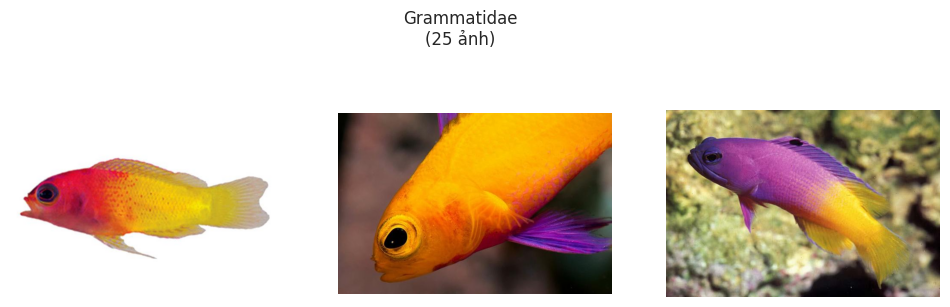

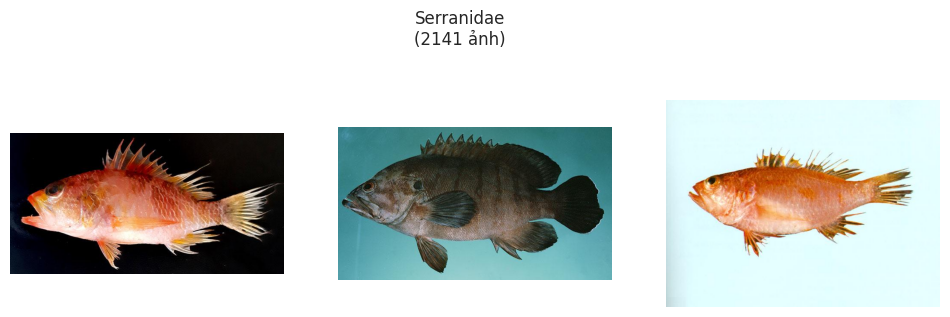

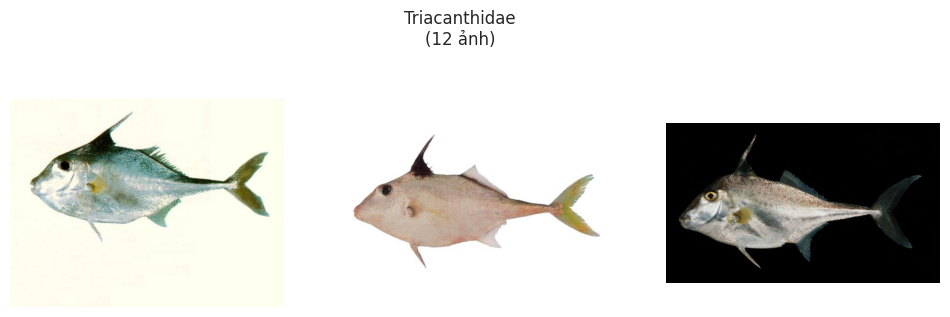

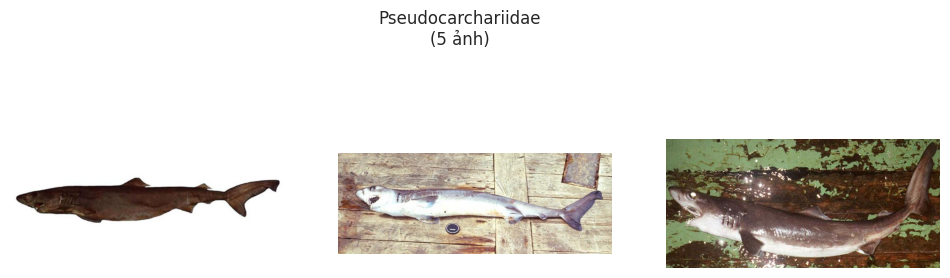

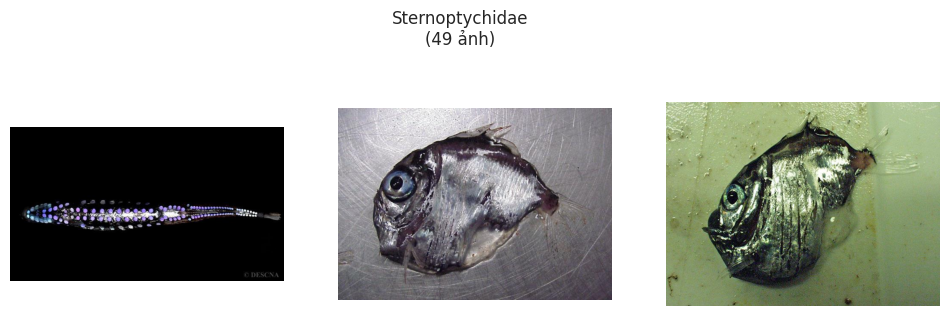

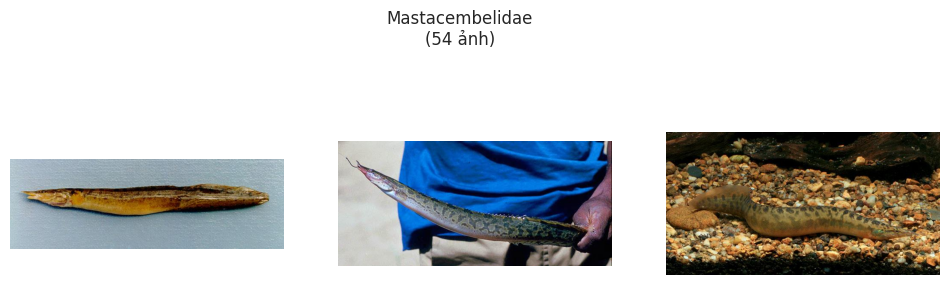

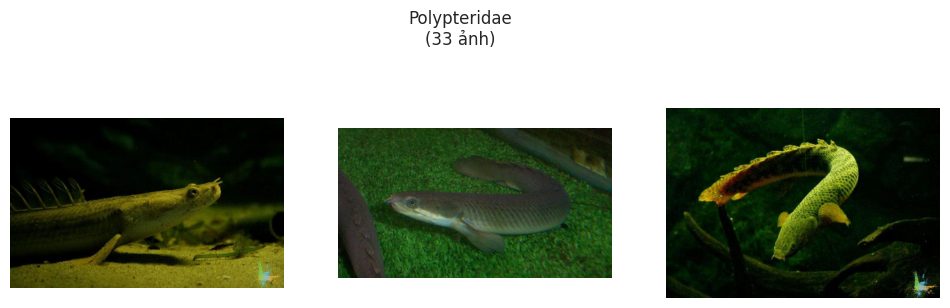

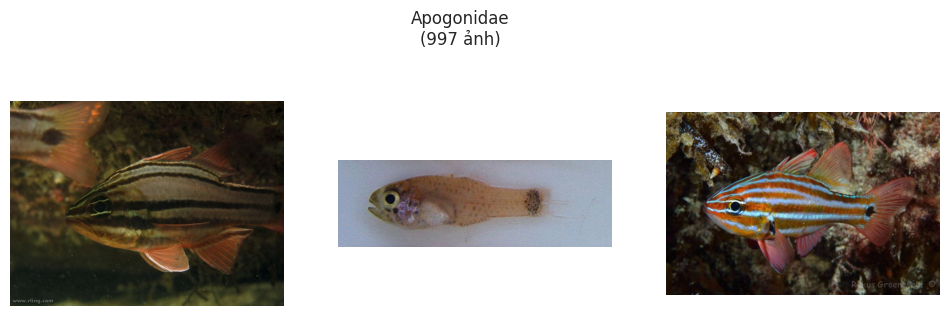

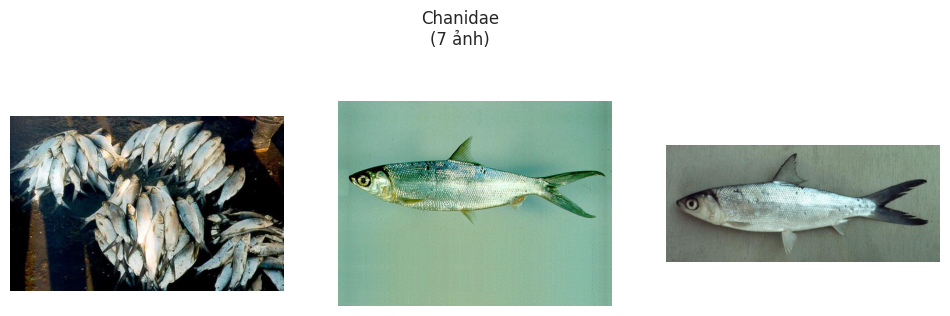

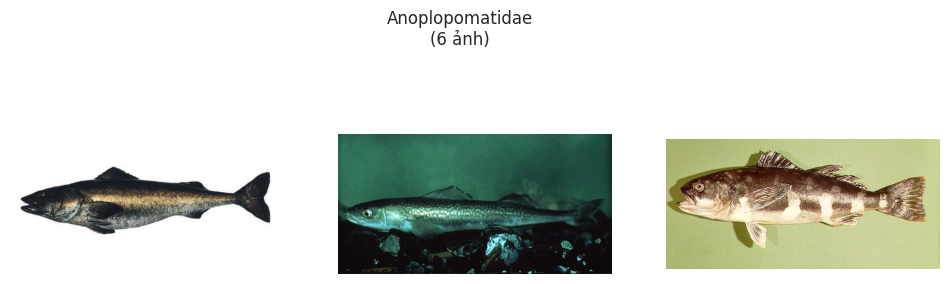

In [56]:
for idx in random_indices:
  show_samples_per_class(df_images, class_names[idx], num=3)

# Ghép 2 dataframe: df_fishnet và df_images

In [57]:
df_images['image_name'] = df_images['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

In [58]:
merged_df = df_fishnet.merge(df_images, on='image_name', how='inner')

In [59]:
merged_df.head()

bbox_id  \
0  00167b08-4a69-44ed-882d-78b6ba31bcd7_0   
1  00167b08-4a69-44ed-882d-78b6ba31bcd7_1   
2  0057ac91-154f-4b38-990e-ee2d20a9d994_0   
3  008a13ed-9cc5-41a9-b420-fa6d84f70ca4_0   
4  008a13ed-9cc5-41a9-b420-fa6d84f70ca4_1   

                                           file_path  \
0  D:\HUS\21. nhap_mon_tri_tue_nhan_tao\FishNet-m...   
1  D:\HUS\21. nhap_mon_tri_tue_nhan_tao\FishNet-m...   
2  D:\HUS\21. nhap_mon_tri_tue_nhan_tao\FishNet-m...   
3  D:\HUS\21. nhap_mon_tri_tue_nhan_tao\FishNet-m...   
4  D:\HUS\21. nhap_mon_tri_tue_nhan_tao\FishNet-m...   

                             image_name family_name_x  bbox_index  x_min  \
0  00167b08-4a69-44ed-882d-78b6ba31bcd7  Acanthuridae           0     12   
1  00167b08-4a69-44ed-882d-78b6ba31bcd7  Acanthuridae           1    441   
2  0057ac91-154f-4b38-990e-ee2d20a9d994  Acanthuridae           0      1   
3  008a13ed-9cc5-41a9-b420-fa6d84f70ca4  Acanthuridae           0    200   
4  008a13ed-9cc5-41a9-b420-fa6d84f70ca4  Acanthuridae           1    361   

   y_min  x_max  y_max  bbox_width  ...  bbox_size  \
0    113     74    210          62  ...      62x97   
1    230    489    326          48  ...      48x96   
2     28    499    252         498  ...    498x224   
3    133    275    179          75  ...      75x46   
4    130    417    156          56  ...      56x26   

                                                path family_name_y width  \
0  /content/data_folder/filtered_images/Acanthuri...  Acanthuridae   500   
1  /content/data_folder/filtered_images/Acanthuri...  Acanthuridae   500   
2  /content/data_folder/filtered_images/Acanthuri...  Acanthuridae   500   
3  /content/data_folder/filtered_images/Acanthuri...  Acanthuridae   500   
4  /content/data_folder/filtered_images/Acanthuri...  Acanthuridae   500   

   height     size     ratio  ratio_fraction megapixels   group  
0     400  500x400  1.250000             5/4     0.2000  Medium  
1     400  500x400  1.250000             5/4     0.2000  Medium  
2     325  500x325  1.538462           20/13     0.1625  Medium  
3     333  500x333  1.501502         500/333     0.1665  Medium  
4     333  500x333  1.501502         500/333     0.1665  Medium  

[5 rows x 21 columns]

In [60]:
# bỏ những cột không dùng đến
merged_df = merged_df.drop(columns=['file_path', 'path', 'family_name_y'])

In [61]:
merged_df.head()

bbox_id  \
0  00167b08-4a69-44ed-882d-78b6ba31bcd7_0   
1  00167b08-4a69-44ed-882d-78b6ba31bcd7_1   
2  0057ac91-154f-4b38-990e-ee2d20a9d994_0   
3  008a13ed-9cc5-41a9-b420-fa6d84f70ca4_0   
4  008a13ed-9cc5-41a9-b420-fa6d84f70ca4_1   

                             image_name family_name_x  bbox_index  x_min  \
0  00167b08-4a69-44ed-882d-78b6ba31bcd7  Acanthuridae           0     12   
1  00167b08-4a69-44ed-882d-78b6ba31bcd7  Acanthuridae           1    441   
2  0057ac91-154f-4b38-990e-ee2d20a9d994  Acanthuridae           0      1   
3  008a13ed-9cc5-41a9-b420-fa6d84f70ca4  Acanthuridae           0    200   
4  008a13ed-9cc5-41a9-b420-fa6d84f70ca4  Acanthuridae           1    361   

   y_min  x_max  y_max  bbox_width  bbox_height bbox_size  width  height  \
0    113     74    210          62           97     62x97    500     400   
1    230    489    326          48           96     48x96    500     400   
2     28    499    252         498          224   498x224    500     325   
3    133    275    179          75           46     75x46    500     333   
4    130    417    156          56           26     56x26    500     333   

      size     ratio ratio_fraction  megapixels   group  
0  500x400  1.250000            5/4      0.2000  Medium  
1  500x400  1.250000            5/4      0.2000  Medium  
2  500x325  1.538462          20/13      0.1625  Medium  
3  500x333  1.501502        500/333      0.1665  Medium  
4  500x333  1.501502        500/333      0.1665  Medium

In [62]:
merged_df['bbox_width_ratio'] = merged_df['bbox_width'] / merged_df['width']
merged_df['bbox_height_ratio'] = merged_df['bbox_height'] / merged_df['height']

merged_df['bbox_area_ratio'] = (merged_df['bbox_width'] * merged_df['bbox_height']) / (merged_df['width'] * merged_df['height'])

In [63]:
merged_df.describe()

bbox_index         x_min         y_min         x_max         y_max  \
count  93399.000000  93399.000000  93399.000000  93399.000000  93399.000000   
mean       0.284864     74.541676     76.863360    474.412895    296.255527   
std        1.395998     80.696039     63.637605    136.815642     86.569155   
min        0.000000      0.000000      0.000000      3.000000      9.000000   
25%        0.000000     17.000000     27.000000    374.000000    238.000000   
50%        0.000000     44.000000     61.000000    489.000000    291.000000   
75%        0.000000    107.000000    111.000000    609.000000    352.000000   
max       31.000000    618.000000    515.000000    787.000000    704.000000   

         bbox_width   bbox_height         width        height         ratio  \
count  93399.000000  93399.000000  93399.000000  93399.000000  93399.000000   
mean     399.871219    219.392167    545.172764    372.414416      1.553865   
std      181.047137    104.372967     93.459411     77.649038      0.517344   
min        3.000000      3.000000     75.000000     53.000000      0.180000   
25%      249.000000    142.000000    500.000000    330.000000      1.333333   
50%      430.000000    212.000000    500.000000    375.000000      1.497006   
75%      578.000000    289.000000    640.000000    427.000000      1.758242   
max      771.000000    605.000000    800.000000    922.000000     12.075472   

         megapixels  bbox_width_ratio  bbox_height_ratio  bbox_area_ratio  
count  93399.000000      93399.000000       93399.000000     93399.000000  
mean       0.201237          0.714484           0.594478         0.467932  
std        0.049765          0.266504           0.250380         0.277339  
min        0.006325          0.006000           0.006466         0.000090  
25%        0.167000          0.530667           0.398559         0.229864  
50%        0.187500          0.820312           0.621253         0.474965  
75%        0.236160          0.934375           0.809037         0.703440  
max        0.529228          1.000000           1.000000         1.000000

In [64]:
merged_df['valid'] = (
    (merged_df['x_min'] >= 0) &
    (merged_df['y_min'] >= 0) &
    (merged_df['x_max'] <= merged_df['width']) &
    (merged_df['y_max'] <= merged_df['height'])
)

In [65]:
merged_df['valid'].value_counts()

valid
True    93399
Name: count, dtype: int64

In [66]:
# Liệt kê top 5 loài cá có nhiều/ít ảnh nhất, với số lượng ảnh và số annotations tương ứng
stats = merged_df.groupby('family_name_x').agg(
    image_count=('image_name', 'nunique'),
    bbox_count=('bbox_id', 'count')
).reset_index()

# Sắp xếp theo số lượng ảnh và lấy 5 dòng đầu/cuối
top_5_stats = stats.sort_values(by='image_count', ascending=False).head(5)
bot_5_stats = stats.sort_values(by='image_count', ascending=True).head(5)

In [67]:
top_5_stats

family_name_x  image_count  bbox_count
231       Labridae         5251        5701
140     Cyprinidae         3694        4109
355  Pomacentridae         3609        4518
91   Centrarchidae         3333        3421
190       Gobiidae         3027        3127

In [68]:
bot_5_stats

family_name_x  image_count  bbox_count
59        Banjosidae            4           4
152    Diplomystidae            4           4
415  Spratelloididae            4           7
225     Indostomidae            4           4
192    Gonorynchidae            4           5

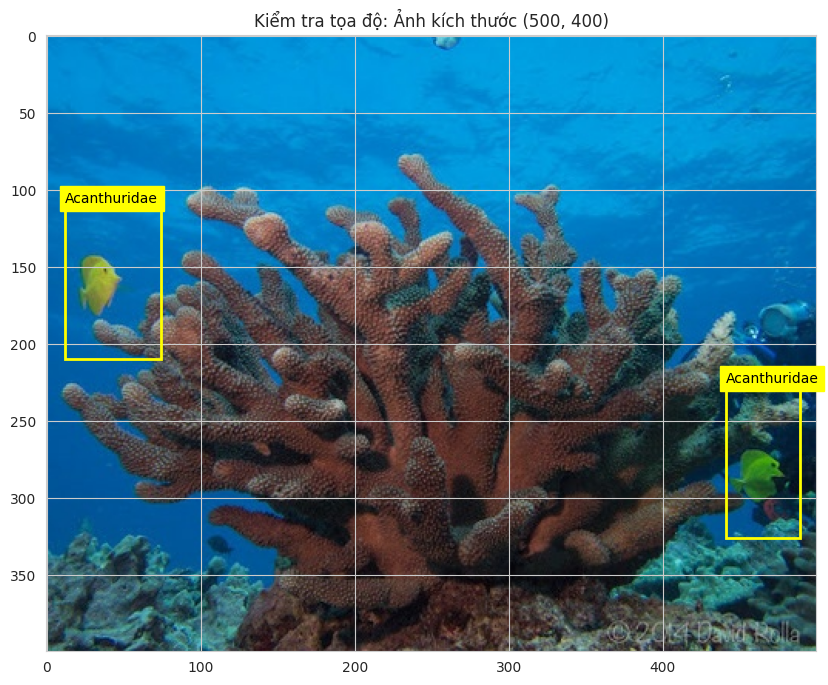

In [69]:
# Đọc ảnh (Thay tên file nếu cần)
# Tên file lấy từ thông tin upload: 00167b08-4a69-44ed-882d-78b6ba31bcd7.jpg
img_path = '/content/data_folder/filtered_images/Acanthuridae/00167b08-4a69-44ed-882d-78b6ba31bcd7.jpg'
img = Image.open(img_path)
img_w, img_h = img.size

# Danh sách Bounding Box [x_center, y_center, w, h] (Chuẩn YOLO)
# Tọa độ này là ước lượng bằng mắt, có thể tinh chỉnh số liệu
boxes = [
    [12, 113, 74, 210],   # Cá bên trái
    [441, 230, 489, 326]  # Cá bên phải
]

# Vẽ hình
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(img)

for box in boxes:
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin

    # Tạo hình chữ nhật
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='yellow', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin-5, 'Acanthuridae', color='black', fontsize=10, backgroundcolor='yellow')

plt.title(f"Kiểm tra tọa độ: Ảnh kích thước {img.size}")
plt.show()

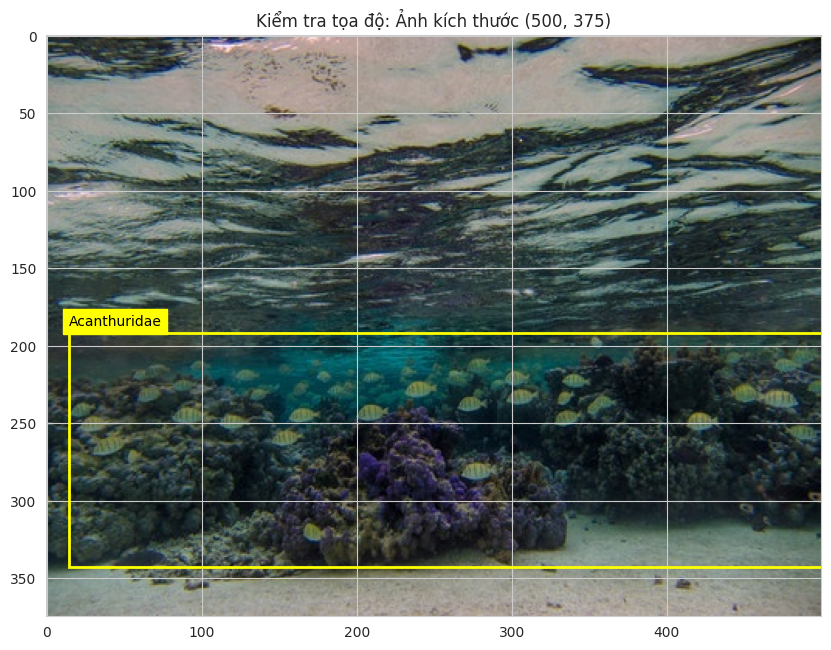

In [70]:
# Load ảnh
img_path = '/content/data_folder/filtered_images/Acanthuridae/0a19177a-c634-4b8e-b6c8-a162565b0cfc.jpg'
img = Image.open(img_path)

# Dữ liệu (Format: x_min, y_min, x_max, y_max)
boxes = [
    [14, 192, 500, 343]
]

# Vẽ lên ảnh
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(img)

for box in boxes:
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin

    # Tạo hình chữ nhật
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='yellow', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin-5, 'Acanthuridae', color='black', fontsize=10, backgroundcolor='yellow')

plt.title(f"Kiểm tra tọa độ: Ảnh kích thước {img.size}")
plt.show()